프로젝트 - Movielens 📽영화🎞 SBR
=======================
***
***

In [1]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

### Data Load
***

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


## 1. 데이터의 전처리
***
* 위와 같이 간단히 구성해 본 데이터셋을 꼼꼼히 살펴보면서 항목별 기본 분석, session length, session time, cleaning 등의 작업을 진행합니다.
* 특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의합니다.

In [3]:
from datetime import datetime

change_date = []
for time in data['Time']:
    temp = dt.datetime.fromtimestamp(time)
    change_date.append(temp)

data['Time'] = change_date
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


### Session Length

In [4]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

In [5]:
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [6]:
session_length.median(), session_length.mean()

(96.0, 165.5975165562914)

In [7]:
session_length.min(), session_length.max()

(20, 2314)

In [8]:
session_length.quantile(0.999)

1343.181000000005

아이디별 세션의 길이는 평균 165이고, 중앙값이 96이다. <br>
그에 비해 세션의 최대값인 2314나 99.9%의 세션의 길이인 1343은 너무나도 길어 이상한 것을 알 수 있다.<br>
하나를 잡고 살펴보도록 하자.

In [9]:
long_session = session_length[session_length==2314].index[0]
data[data['UserId']==long_session]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,2000-08-03 20:09:52
697168,4169,2617,4,2000-08-03 20:09:52
697185,4169,2628,4,2000-08-03 20:09:52
697219,4169,2653,4,2000-08-03 20:09:52
697275,4169,423,3,2000-08-03 20:09:52
...,...,...,...,...
697882,4169,3754,2,2002-06-15 20:52:27
695702,4169,1413,3,2002-06-15 21:03:51
697358,4169,494,4,2002-06-15 21:16:00
695945,4169,1804,2,2002-06-15 21:16:23


Time 컬럼을 보면 동일한 값이 중복된다는 것을 확인할 수 있다.

In [10]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

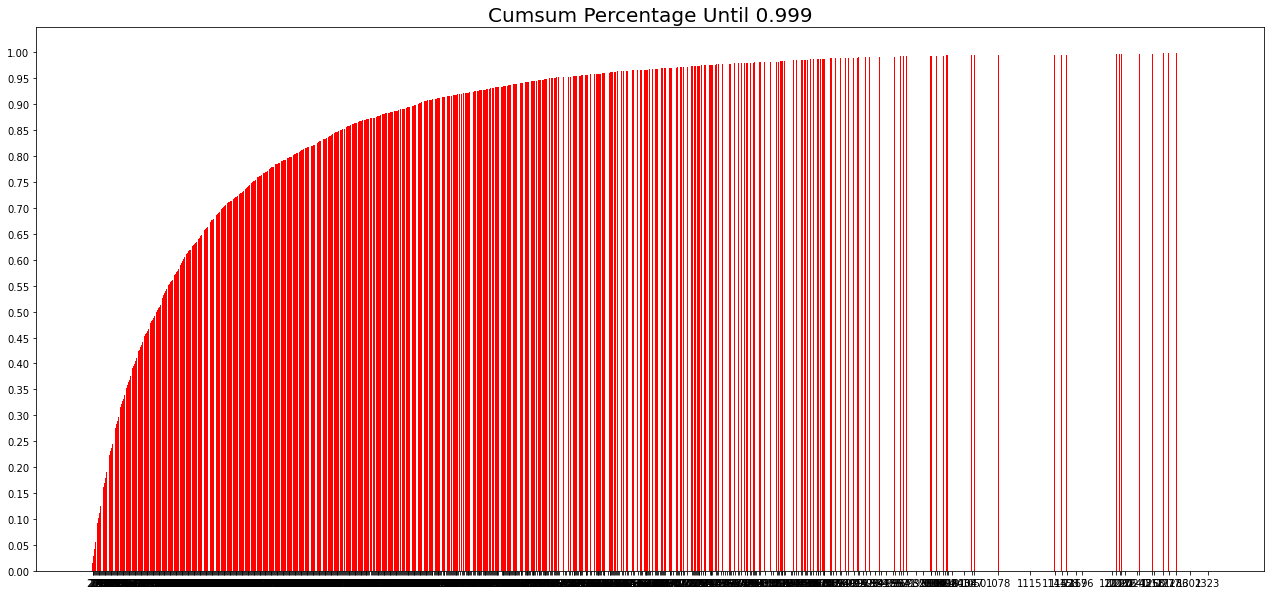

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(22, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

### Session Time

In [12]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


## 2. 미니 배치의 구성
***
* 실습 코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다. Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.
* 단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다.

### Train / Valid / Test split
* 34개월 데이터이기에
* train: 처음부터 마지막 2달 전(1~32)
* valid: test 1달 전(33)
* test: 마지막 1개월(34)

In [13]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('UserId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['UserId'].isin(session_in_train)]
    after_date = data[data['UserId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [14]:
tr, test = split_by_date(data, n_days=30)
tr, val = split_by_date(tr, n_days=30)

In [15]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [16]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 919748
	 Sessions: 5858
	 Items: 3693
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-12-30 02:26:14

* valid Set Stats Info
	 Events: 29494
	 Sessions: 79
	 Items: 2977
	 First Time : 2000-05-05 17:20:21
	 Last Time : 2003-01-29 03:00:40

* test Set Stats Info
	 Events: 50952
	 Sessions: 103
	 Items: 3198
	 First Time : 2000-05-01 11:15:13
	 Last Time : 2003-02-28 17:49:50



In [17]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [18]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

### Data Pipeline
### SessionDataset

In [19]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

train 데이터로 <code>SessionDataset</code> 객체를 만들고 인스턴스 변수들을 살펴보겠습니다.<br>
<code>click_offsets</code> 변수는 각 세션이 시작된 인덱스를 담고 있습니다.<br>
<code>session_idx</code> 변수는 각 세션을 인덱싱한 <code>np.array</code> 입니다.<br>

In [20]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [21]:
tr_dataset.click_offsets

array([     0,     53,    182, ..., 919284, 919407, 919748], dtype=int32)

In [22]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 5855, 5856, 5857])

### SessionDataLoader
<code>SessionDataset</code> 객체를 받아서 Session-Parallel mini-batch를 만드는 클래스를 만듭니다.<br>
<code>__iter__</code> 메서드는 모델 인풋, 라벨, 세션이 끝나는 곳의 위치를 <code>yield</code>합니다.<br>
mask는 후에 RNN Cell State를 초기화하는데 사용할 것입니다.<br>

In [23]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished


In [24]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [25]:
iter_ex = iter(tr_data_loader)

In [26]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 65 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []


## 3. 모델 구성
***

### Evaluation Metric

모델 성능 평가를 위한 지표를 보겠습니다.<br>
모델 성능에 대한 지표로 precision이나 recall이 있습니다.<br>
Session-Based Recommendation Task에서는 모델이 k개의 아이템을 제시했을 때, 유저가 클릭/ 구매한 n개의 아이템이 많아야 좋습니다.<br>
이 때문에 recall의 개념을 확장한 <code>recall@k</code> 지표, precision의 개념을 확장한 <code>Mean Average Precision@k</code> 지표 등을 사용합니다.<br>
추천에서는 몇 번째로 맞추느냐도 중요합니다. 구글에서 검색했을 때 1페이지에 원하는 결과가 나오지 않고 2페이지에 나온다면 유저 반응이 크게 떨어질 것입니다.<br>
따라서 순서에 민감한 지표인 <code>MRR</code>, <code>NDCG</code> 같은 지표도 사용합니다.<br>
이번 자료에서는 <code>MRR</code>과 <code>Recall@k</code>를 사용하겠습니다. <code>MRR</code>은 정답 아이템이 나온 순번의 역수 값입니다.<br>
따라서 정답 아이템이 추천 결과 앞쪽 순번에 나온다면 지표가 높아질 것이고 뒤쪽에 나오거나 안 나온다면 지표가 낮아질 것입니다.<br>

In [27]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

### Model Architecture

In [28]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [29]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

모델에 사용할 hyper-parameter를 class형식으로 관리하겠습니다.

In [30]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)

In [31]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(64, 1, 3693)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      561750    
_________________________________________________________________
dropout (Dropout)            (64, 50)                  0         
_________________________________________________________________
dense (Dense)                (64, 3693)                188343    
Total params: 750,093
Trainable params: 750,093
Non-trainable params: 0
_________________________________________________________________


## 4. 모델 학습
***

In [32]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [33]:
train_model(model, args)

Evaluation:  29%|██▊       | 131/459 [00:35<01:28,  3.70it/s]


	 - Recall@20 epoch 1: 0.256083
	 - MRR@20    epoch 1: 0.066554



Evaluation:  29%|██▊       | 131/459 [00:34<01:26,  3.80it/s]


	 - Recall@20 epoch 2: 0.291627
	 - MRR@20    epoch 2: 0.080638



Evaluation:  29%|██▊       | 131/459 [00:34<01:26,  3.81it/s]


	 - Recall@20 epoch 3: 0.303316
	 - MRR@20    epoch 3: 0.087687



Evaluation:  29%|██▊       | 131/459 [00:34<01:26,  3.79it/s]


	 - Recall@20 epoch 4: 0.309399
	 - MRR@20    epoch 4: 0.091783



Evaluation:  29%|██▊       | 131/459 [00:34<01:25,  3.83it/s]


	 - Recall@20 epoch 5: 0.315005
	 - MRR@20    epoch 5: 0.093892



Evaluation:  29%|██▊       | 131/459 [00:33<01:24,  3.87it/s]


	 - Recall@20 epoch 6: 0.317271
	 - MRR@20    epoch 6: 0.095725



Evaluation:  29%|██▊       | 131/459 [00:34<01:25,  3.84it/s]


	 - Recall@20 epoch 7: 0.317629
	 - MRR@20    epoch 7: 0.096126



Evaluation:  29%|██▊       | 131/459 [00:33<01:24,  3.88it/s]


	 - Recall@20 epoch 8: 0.320969
	 - MRR@20    epoch 8: 0.096382



Evaluation:  29%|██▊       | 131/459 [00:34<01:25,  3.85it/s]


	 - Recall@20 epoch 9: 0.321207
	 - MRR@20    epoch 9: 0.097827



Evaluation:  29%|██▊       | 131/459 [00:33<01:23,  3.92it/s]

	 - Recall@20 epoch 10: 0.318583
	 - MRR@20    epoch 10: 0.096936



## 5. 모델 테스트
***

In [34]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  53%|█████▎    | 418/794 [01:48<01:37,  3.87it/s]

	 - Recall@20: 0.296090
	 - MRR@20: 0.089215



### 파라미터 변경에 따른 변화
***
1. batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20

* Recall@20: 0.280465
* MRR@20: 0.081168

2. batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20

* Recall@20: 0.296165
* MRR@20: 0.086394

3. batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20

* Recall@20: 0.296090
* MRR@20: 0.089215

#### epoch를 올리면 수치가 개선됨을 확인할 수 있다.

<kbd>회고</kbd>
===
***
***
중복되는 값들이 많아서 그게 뭔지 고민을 해봤다.<br>
넷플릭스 같은 플랫폼에 들어가서 틀어보고 마음에 안들면 바로 끄고 다른 영상을 틀었다는 느낌으로 생각했다.<br>
중복 값이 많아서 중복된 값을 지우지 않았다.<br>

학습을 진행할 때 에러가 났다.<br>
배치사이즈를 줄이니까 에러가 해결이 되어서 학습을 시켰다.<br>

방학기간에 쉬다가 다시 하려고 하니 적응이 잘 안된다...